# **SetUp**

In [20]:
import zipfile
import os

# Define the folder path and the ZIP file path
folder_path = '/content/ml_features.parquet'
zip_file_path = 'ml_features.zip'

# Create a ZIP file
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file))


In [1]:
# Install PySpark version 3.1.2 silently
!pip install pyspark==3.1.2 -q
# Install findSpark silently
!pip install findspark -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 11.6 MB/s eta 0:00:00


In [2]:
!unzip /content/data_parquet.zip
# !unzip /content/data_csv.zip

Archive:  /content/data_parquet.zip
 extracting: content/sales_parquet/part-00002-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet  
 extracting: content/sales_parquet/.part-00002-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet.crc  
 extracting: content/sales_parquet/part-00004-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet  
 extracting: content/sales_parquet/part-00003-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet  
 extracting: content/sales_parquet/.part-00007-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet.crc  
 extracting: content/sales_parquet/.part-00004-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet.crc  
 extracting: content/sales_parquet/_SUCCESS  
 extracting: content/sales_parquet/part-00000-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet  
 extracting: content/sales_parquet/.part-00003-a63d683f-7c02-41ae-8b95-51bc74fdab48-c000.snappy.parquet.crc  
 extracting: content/sales_parquet/.part-00005-a63d683f-7c

In [3]:
# Suppressing warnings by defining a function 'warn' that does nothing
def warn(*args, **kwargs):
    pass

# Importing the 'warnings' module to handle warnings
import warnings

# Overriding the 'warn' function in the 'warnings' module with the defined function to suppress warnings
warnings.warn = warn

# Filtering out all warnings to be ignored
warnings.filterwarnings('ignore')

# FindSpark simplifies the process of using Apache Spark with Python
# Importing the 'findspark' module
import findspark

# Initializing FindSpark to locate Spark installation
findspark.init()

# **Init**

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull
from pyspark.sql.functions import to_date, year, month, dayofmonth, weekofyear
from pyspark.sql.functions import avg, sum, count, max, round, countDistinct, when, stddev
from pyspark.sql import functions as F
from pyspark.sql import Window

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/XXlNzqYcxqkTbllc-tL_0w/Retailsales.csv

--2024-10-09 20:19:59--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/XXlNzqYcxqkTbllc-tL_0w/Retailsales.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47593992 (45M) [text/csv]
Saving to: ‘Retailsales.csv’

Retailsales.csv     100%[===================>]  45.39M  14.3MB/s    in 3.4s    

2024-10-09 20:20:04 (13.4 MB/s) - ‘Retailsales.csv’ saved [47593992/47593992]



# **Tiền Xử lý**

In [5]:
# Tạo Spark session
spark = SparkSession.builder.appName("Practice Project Optimized").getOrCreate()

In [ ]:
# Đọc file CSV và chuyển thành file Parquet để truy xuất nhanh hơn
df = spark.read.csv("/content/sales.csv/sales.csv", header=True, inferSchema=True)
df.write.parquet("/content/sales_parquet", mode="overwrite")

In [13]:
# Đọc dữ liệu từ Parquet để tăng tốc độ xử lý
df = spark.read.parquet("/content/content/sales_parquet")

# Cache DataFrame vì nó sẽ được sử dụng lại nhiều lần
df.cache()

# Hiển thị schema
df.printSchema()

# Xóa các cột không cần thiết
columns_to_drop = ["promo_type_1", "promo_type_2", "promo_bin_1", "promo_bin_2", "promo_discount_2", "promo_discount_type_2"]
df = df.drop(*columns_to_drop)

# Xóa các giá trị null
df = df.dropna()

# Chuyển đổi cột 'sales', 'stock' sang kiểu số nguyên (Integer)
df = df.withColumn("sales", col("sales").cast("int"))
df = df.withColumn("stock", col("stock").cast("int"))

# Chuyển đổi cột 'date' sang định dạng date
df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# Sắp xếp theo 'date' tăng dần để các truy vấn sau không cần sắp xếp lại nữa
df_sorted = df.orderBy("date", ascending=True)
df_sorted.cache()



root
 |-- product_id: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- sales: double (nullable = true)
 |-- revenue: double (nullable = true)
 |-- stock: double (nullable = true)
 |-- price: double (nullable = true)
 |-- promo_type_1: string (nullable = true)
 |-- promo_bin_1: string (nullable = true)
 |-- promo_type_2: string (nullable = true)
 |-- promo_bin_2: string (nullable = true)
 |-- promo_discount_2: double (nullable = true)
 |-- promo_discount_type_2: string (nullable = true)



DataFrame[product_id: string, store_id: string, date: date, sales: int, revenue: double, stock: int, price: double]

In [16]:
# Tạo các đặc trưng thời gian cơ bản
df_sorted = df_sorted.withColumn("year", year(col("date"))) \
       .withColumn("month", month(col("date"))) \
       .withColumn("week_of_year", weekofyear(col("date")))

# Xác định các mùa dựa trên tháng
df_sorted = df_sorted.withColumn("season",
                   when((col("month") >= 3) & (col("month") <= 5), 1)
                   .when((col("month") >= 6) & (col("month") <= 8), 2)
                   .when((col("month") >= 9) & (col("month") <= 11), 3)
                   .otherwise(4))

# Cửa sổ window partition theo product_id và store_id để tính các giá trị moving average và cumulative sum
window_spec = Window.partitionBy("product_id", "store_id").orderBy("date").rowsBetween(-7, 0)

# Tạo các đặc trưng moving average cho lợi nhuận
df_sorted = df_sorted.withColumn("revenue_avg", avg(col("revenue")).over(window_spec))

# Tạo đặc trưng cumulative sum cho lợi nhuận và hàng tồn kho
df_sorted = df_sorted.withColumn("revenue_cumsum", sum(col("revenue")).over(window_spec)) \
       .withColumn("sales_cumsum", sum(col("sales")).over(window_spec)) \
       .withColumn("stock_cumsum", sum(col("stock")).over(window_spec))

# Mức độ biến động giá (Price Volatility) - Độ lệch chuẩn của giá theo thời gian cho từng sản phẩm
df_sorted = df_sorted.withColumn("price_volatility", stddev(col("price")).over(window_spec))

# 4. Số ngày hết hàng (Stockout Days)
df_sorted = df_sorted.withColumn("stockout", when(col("stock") == 0, 1).otherwise(0))
df_sorted = df_sorted.withColumn("stockout_days", sum(col("stockout")).over(window_spec))

# Tạo cột thể hiện "year_offset" - số năm kể từ năm đầu tiên
df_sorted = df_sorted.withColumn("year_offset", col("year") - 2017)

# Xóa các cột không cần thiết
columns_to_drop = ["product_id", "store_id", "date", "sales", "revenue", "stock", "stockout"]
df_sorted = df_sorted.drop(*columns_to_drop)
# Loại bỏ các hàng null sau khi tạo lag và moving average
df_sorted = df_sorted.dropna()

# Lưu lại DataFrame với các đặc trưng thời gian vào Parquet
output_path = "/content/ml_features.parquet"
df_sorted.write.parquet(output_path)

In [19]:
# Hiển thị schema
df_sorted.printSchema()
df_sorted.tail(50)

root
 |-- price: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- season: integer (nullable = false)
 |-- revenue_avg: double (nullable = true)
 |-- revenue_cumsum: double (nullable = true)
 |-- sales_cumsum: long (nullable = true)
 |-- stock_cumsum: long (nullable = true)
 |-- price_volatility: double (nullable = true)
 |-- stockout_days: long (nullable = true)
 |-- year_offset: integer (nullable = true)



[Row(price=21.9, year=2019, month=9, week_of_year=37, season=3, revenue_avg=13.37, revenue_cumsum=106.96, sales_cumsum=8, stock_cumsum=117, price_volatility=0.0, stockout_days=0, year_offset=2),
 Row(price=21.9, year=2019, month=9, week_of_year=37, season=3, revenue_avg=14.11125, revenue_cumsum=112.89, sales_cumsum=8, stock_cumsum=109, price_volatility=0.0, stockout_days=0, year_offset=2),
 Row(price=21.9, year=2019, month=9, week_of_year=37, season=3, revenue_avg=12.5325, revenue_cumsum=100.26, sales_cumsum=7, stock_cumsum=102, price_volatility=0.0, stockout_days=0, year_offset=2),
 Row(price=21.9, year=2019, month=9, week_of_year=37, season=3, revenue_avg=7.797499999999999, revenue_cumsum=62.379999999999995, sales_cumsum=4, stock_cumsum=98, price_volatility=0.0, stockout_days=0, year_offset=2),
 Row(price=21.9, year=2019, month=9, week_of_year=38, season=3, revenue_avg=6.21875, revenue_cumsum=49.75, sales_cumsum=3, stock_cumsum=95, price_volatility=0.0, stockout_days=0, year_offset=2

In [ ]:
# Mô tả số liệu thống kê cho các cột sales, revenue, stock, price
df_sorted.describe(['sales', 'revenue', 'stock', 'price']).show(5)

+-------+-------------------+-----------------+------------------+------------------+
|summary|              sales|          revenue|             stock|             price|
+-------+-------------------+-----------------+------------------+------------------+
|  count|           17699113|         17699113|          17699113|          17699113|
|   mean|0.42183921872242974|2.040927829038659| 15.54860839636427|15.212510579477838|
| stddev| 14.879948102769461|40.43108421174858|35.229339237963174|31.466275893528948|
|    min|                  0|              0.0|                 0|              0.01|
|    max|              43301|        84197.961|              4716|            1599.0|
+-------+-------------------+-----------------+------------------+------------------+



In [ ]:
# Kiểm tra null
df_sorted.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns]).show()

+----------+--------+----+-----+-------+-----+-----+
|product_id|store_id|date|sales|revenue|stock|price|
+----------+--------+----+-----+-------+-----+-----+
|         0|       0|   0|    0|      0|    0|    0|
+----------+--------+----+-----+-------+-----+-----+



In [ ]:
# Kiểm tra tính duy nhất
unique_counts = df_sorted.select([countDistinct(col(column)).alias(column) for column in df.columns])
unique_counts.show()

+----------+--------+----+-----+-------+-----+-----+
|product_id|store_id|date|sales|revenue|stock|price|
+----------+--------+----+-----+-------+-----+-----+
|       622|     144|1033|  317|  13769| 1745|  621|
+----------+--------+----+-----+-------+-----+-----+



# **Truy Vấn Chính**

In [ ]:
# Tạo bảng tạm thời cho Spark SQL
df_sorted.createOrReplaceTempView("sales_data_sorted")

In [ ]:
# 1. Tổng số lượng bán, doanh thu, số hàng tồn kho, giá bán của mỗi sản phẩm theo ngày
sum_by_date_product = spark.sql("""
    SELECT date, product_id, SUM(sales) AS sum_sales, ROUND(SUM(revenue), 2) AS sum_revenue, SUM(stock) AS sum_stock, ROUND(SUM(price), 2) AS sum_price
    FROM sales_data_sorted
    GROUP BY date, product_id
""")
sum_by_date_product.show(5)

+----------+----------+---------+-----------+---------+---------+
|      date|product_id|sum_sales|sum_revenue|sum_stock|sum_price|
+----------+----------+---------+-----------+---------+---------+
|2017-01-02|     P0001|        6|      31.79|      195|   218.75|
|2017-01-02|     P0004|        1|       3.81|       58|     22.5|
|2017-01-02|     P0005|        0|        0.0|      160|    983.1|
|2017-01-02|     P0011|        0|        0.0|       78|    698.6|
|2017-01-02|     P0014|        0|        0.0|        2|   119.98|
+----------+----------+---------+-----------+---------+---------+
only showing top 5 rows



In [ ]:
# 2. Số lượng bán, doanh thu, số hàng tồn kho, giá bán trung bình của mỗi sản phẩm theo ngày
avg_by_date_product = spark.sql("""
    SELECT date, product_id, ROUND(AVG(sales), 2) AS avg_sales, ROUND(AVG(revenue), 2) AS avg_revenue,
           ROUND(AVG(stock), 2) AS avg_stock, ROUND(AVG(price), 2) AS avg_price
    FROM sales_data_sorted
    GROUP BY date, product_id
""")
avg_by_date_product.show(5)

+----------+----------+---------+-----------+---------+---------+
|      date|product_id|avg_sales|avg_revenue|avg_stock|avg_price|
+----------+----------+---------+-----------+---------+---------+
|2017-01-02|     P0001|     0.17|       0.91|     5.57|     6.25|
|2017-01-02|     P0004|      0.2|       0.76|     11.6|      4.5|
|2017-01-02|     P0005|      0.0|        0.0|     5.52|     33.9|
|2017-01-02|     P0011|      0.0|        0.0|     5.57|     49.9|
|2017-01-02|     P0014|      0.0|        0.0|      1.0|    59.99|
+----------+----------+---------+-----------+---------+---------+
only showing top 5 rows



In [ ]:
# 3. Tổng số lượng bán, doanh thu, số hàng tồn kho, giá bán của mỗi cửa hàng theo ngày
sum_by_date_store = spark.sql("""
    SELECT date, store_id, SUM(sales) AS sum_sales, ROUND(SUM(revenue), 2) AS sum_revenue, SUM(stock) AS sum_stock, ROUND(SUM(price), 2) AS sum_price
    FROM sales_data_sorted
    GROUP BY date, store_id
""")
sum_by_date_store.show(5)

+----------+--------+---------+-----------+---------+---------+
|      date|store_id|sum_sales|sum_revenue|sum_stock|sum_price|
+----------+--------+---------+-----------+---------+---------+
|2017-01-02|   S0002|       73|     171.59|     2632|  2012.29|
|2017-01-02|   S0012|       38|      68.52|     1936|  1317.74|
|2017-01-02|   S0013|       65|     178.95|     2818|  1983.56|
|2017-01-02|   S0023|       59|     156.83|     2792|  1952.05|
|2017-01-02|   S0025|       25|      69.64|     1667|   734.94|
+----------+--------+---------+-----------+---------+---------+
only showing top 5 rows



In [ ]:
# 4. Số lượng bán, doanh thu, số hàng tồn kho, giá bán trung bình của mỗi cửa hàng theo ngày
avg_by_date_store = spark.sql("""
    SELECT date, store_id, ROUND(AVG(sales), 2) AS avg_sales, ROUND(AVG(revenue), 2) AS avg_revenue,
           ROUND(AVG(stock), 2) AS avg_stock, ROUND(AVG(price), 2) AS avg_price
    FROM sales_data_sorted
    GROUP BY date, store_id
""")
avg_by_date_store.show(5)

+----------+--------+---------+-----------+---------+---------+
|      date|store_id|avg_sales|avg_revenue|avg_stock|avg_price|
+----------+--------+---------+-----------+---------+---------+
|2017-01-02|   S0002|      0.4|       0.94|    14.38|     11.0|
|2017-01-02|   S0012|     0.26|       0.47|    13.26|     9.03|
|2017-01-02|   S0013|     0.36|       0.98|     15.4|    10.84|
|2017-01-02|   S0023|     0.31|       0.82|    14.62|    10.22|
|2017-01-02|   S0025|     0.24|       0.68|    16.18|     7.14|
+----------+--------+---------+-----------+---------+---------+
only showing top 5 rows



In [ ]:
# Ghi dữ liệu với partition theo 'date' và 'product_id'
sum_by_date_product.write.parquet("/content/sum_by_date_product", mode="overwrite")

# Ghi dữ liệu với partition theo 'date' và 'product_id'
avg_by_date_product.write.parquet("/content/avg_by_date_product", mode="overwrite")

# Ghi dữ liệu với partition theo 'date' và 'store_id'
sum_by_date_store.write.parquet("/content/sum_by_date_store", mode="overwrite")

# Ghi dữ liệu với partition theo 'date' và 'store_id'
avg_by_date_store.write.parquet("/content/avg_by_date_store", mode="overwrite")

print("All queries executed and saved to partitioned Parquet files.")

All queries executed and saved to partitioned Parquet files.


# **Truy Vấn Phụ**

In [ ]:
# Khởi tạo Spark session
spark = SparkSession.builder.appName("Parquet Reader").getOrCreate()

# Đọc các file parquet
sum_by_date_product = spark.read.parquet("/content/sum_by_date_product")
avg_by_date_product = spark.read.parquet("/content/avg_by_date_product")
sum_by_date_store = spark.read.parquet("/content/sum_by_date_store")
avg_by_date_store = spark.read.parquet("/content/avg_by_date_store")

# Hiển thị một số dòng từ mỗi bảng để kiểm tra
sum_by_date_product.show(5)
avg_by_date_product.show(5)
sum_by_date_store.show(5)
avg_by_date_store.show(5)


+----------+----------+---------+-----------+---------+
|      date|product_id|sum_sales|sum_revenue|sum_stock|
+----------+----------+---------+-----------+---------+
|2018-08-01|     P0001|        4|      29.67|      150|
|2018-08-01|     P0002|        0|        0.0|       28|
|2018-08-01|     P0004|        0|        0.0|       51|
|2018-08-01|     P0005|        1|      38.05|      149|
|2018-08-01|     P0006|        0|        0.0|       58|
+----------+----------+---------+-----------+---------+
only showing top 5 rows

+----------+----------+---------+-----------+---------+---------+
|      date|product_id|avg_sales|avg_revenue|avg_stock|avg_price|
+----------+----------+---------+-----------+---------+---------+
|2019-09-21|     P0001|     0.36|       3.37|      7.0|    10.95|
|2019-09-21|     P0002|      0.0|        0.0|      3.0|    272.0|
|2019-09-21|     P0005|     0.12|       4.88|     5.12|     49.9|
|2019-09-21|     P0006|      0.0|        0.0|      1.5|     18.0|
|2019-09-

In [ ]:

# Truy vấn tổng doanh thu và số lượng bán của các sản phẩm
top_products_sales = sum_by_date_product \
    .groupBy("product_id") \
    .agg(
        F.sum("sum_sales").alias("total_sales"),
        F.round(F.sum("sum_revenue"), 2).alias("total_revenue")
    ) \
    .orderBy(F.desc("total_sales"), F.desc("total_revenue")) \
    .limit(10)

# Hiển thị kết quả
top_products_sales.show()



+----------+-----------+-------------+
|product_id|total_sales|total_revenue|
+----------+-----------+-------------+
|     P0103|     816563|   2491280.47|
|     P0438|     512491|    198450.54|
|     P0364|     263474|     298142.1|
|     P0051|     221261|    165057.49|
|     P0388|     209738|     314607.0|
|     P0131|     206596|    515384.47|
|     P0569|     183911|    589651.28|
|     P0333|     165005|    377386.55|
|     P0590|     157849|     96874.83|
|     P0500|     156500|   1264167.45|
+----------+-----------+-------------+



In [ ]:
# Truy vấn để tìm cửa hàng có hiệu suất tốt nhất
top_stores_sales = sum_by_date_store \
    .groupBy("store_id") \
    .agg(
        F.sum("sum_sales").alias("total_sales"),
        F.round(F.sum("sum_revenue"), 2).alias("total_revenue")
    ) \
    .orderBy(F.desc("total_sales"), F.desc("total_revenue")) \
    .limit(10)

# Hiển thị kết quả
top_stores_sales.show()

+--------+-----------+-------------+
|store_id|total_sales|total_revenue|
+--------+-----------+-------------+
|   S0085|     430846|   2140927.44|
|   S0097|     321047|   1483944.68|
|   S0026|     216193|   1313174.19|
|   S0062|     207034|   1295918.64|
|   S0038|     201449|    1014895.6|
|   S0020|     195559|   1050640.63|
|   S0115|     167515|    971482.69|
|   S0095|     143892|   1007497.97|
|   S0001|     136920|    844096.73|
|   S0104|     132481|    675236.83|
+--------+-----------+-------------+



In [ ]:
# Truy vấn để lấy giá bán trung bình của các sản phẩm qua thời gian
avg_price_by_date = avg_by_date_product \
    .select("date", "product_id", "avg_price") \
    .orderBy("date")

# Hiển thị kết quả
avg_price_by_date.show()


+----------+----------+---------+
|      date|product_id|avg_price|
+----------+----------+---------+
|2017-01-02|     P0059|     9.75|
|2017-01-02|     P0035|     2.48|
|2017-01-02|     P0057|     12.9|
|2017-01-02|     P0015|      2.6|
|2017-01-02|     P0024|     1.95|
|2017-01-02|     P0050|     5.95|
|2017-01-02|     P0055|     3.49|
|2017-01-02|     P0004|      4.5|
|2017-01-02|     P0014|    59.99|
|2017-01-02|     P0017|     1.49|
|2017-01-02|     P0018|     1.95|
|2017-01-02|     P0043|     22.9|
|2017-01-02|     P0046|     34.5|
|2017-01-02|     P0051|      0.7|
|2017-01-02|     P0054|     3.95|
|2017-01-02|     P0001|     6.25|
|2017-01-02|     P0061|      8.0|
|2017-01-02|     P0005|     33.9|
|2017-01-02|     P0011|     49.9|
|2017-01-02|     P0016|      2.0|
+----------+----------+---------+
only showing top 20 rows



In [ ]:

# Truy vấn để tính tương quan giữa giá bán và số lượng bán ra theo cửa hàng, làm tròn đến 2 chữ số thập phân
correlation_price_sales_store = avg_by_date_store \
    .groupBy("store_id") \
    .agg(F.round(F.corr("avg_sales", "avg_price"), 4).alias("corr_sales_price")) \
    .filter(F.col("corr_sales_price").isNotNull()) \
    .orderBy(F.desc("corr_sales_price"))

# Hiển thị kết quả
correlation_price_sales_store.show()


+--------+----------------+
|store_id|corr_sales_price|
+--------+----------------+
|   S0008|          0.4118|
|   S0076|          0.4019|
|   S0119|          0.3257|
|   S0112|          0.2445|
|   S0034|          0.2403|
|   S0114|          0.2045|
|   S0069|          0.1669|
|   S0050|          0.1658|
|   S0134|          0.1568|
|   S0068|          0.1421|
|   S0086|           0.141|
|   S0133|          0.1303|
|   S0093|          0.1226|
|   S0074|          0.1116|
|   S0016|          0.1062|
|   S0094|          0.0895|
|   S0117|          0.0813|
|   S0118|          0.0666|
|   S0009|          0.0658|
|   S0030|          0.0644|
+--------+----------------+
only showing top 20 rows



# **Biểu đồ cho truy vấn chính**

In [ ]:
# Chuyển đổi từ PySpark DataFrame sang Pandas DataFrame
sum_by_date_product_df = sum_by_date_product.toPandas()
avg_by_date_product_df = avg_by_date_product.toPandas()
sum_by_date_store_df = sum_by_date_store.toPandas()
avg_by_date_store_df = avg_by_date_store.toPandas()


In [ ]:
print(avg_by_date_product_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445128 entries, 0 to 445127
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         445128 non-null  object 
 1   product_id   445128 non-null  object 
 2   avg_sales    445128 non-null  float64
 3   avg_revenue  445128 non-null  float64
 4   avg_stock    445128 non-null  float64
 5   avg_price    445128 non-null  float64
dtypes: float64(4), object(2)
memory usage: 20.4+ MB
None


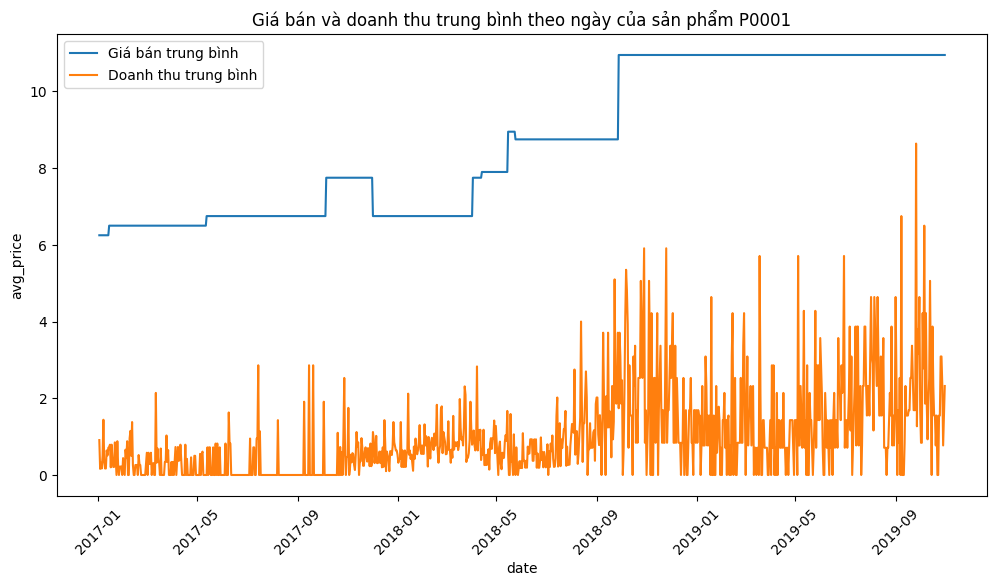

In [ ]:
# Biểu đồ xu hướng tổng doanh thu và số lượng bán theo ngày (sum_by_date_product)
# Lọc dữ liệu theo product_id
filtered_df = avg_by_date_product_df[avg_by_date_product_df['product_id'] == "P0001"]
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='date', y='avg_price', label='Giá bán trung bình')
sns.lineplot(data=filtered_df, x='date', y='avg_revenue', label='Doanh thu trung bình')
plt.title("Giá bán và doanh thu trung bình theo ngày của sản phẩm P0001")
plt.xticks(rotation=45)
plt.legend()
plt.show()



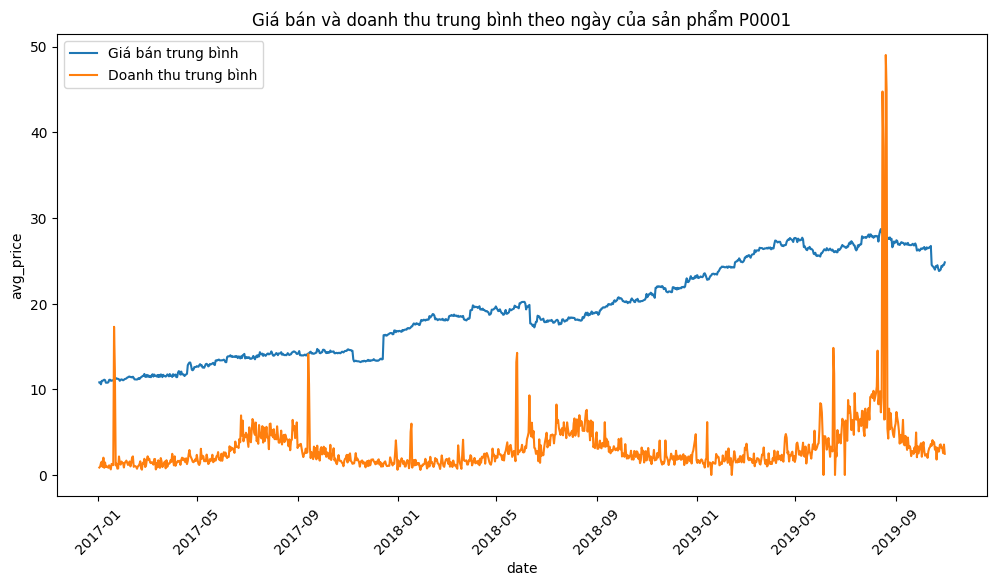

In [ ]:
# Biểu đồ xu hướng tổng doanh thu và số lượng bán theo ngày (sum_by_date_product)
# Lọc dữ liệu theo product_id
filtered_df = avg_by_date_store_df[avg_by_date_store_df['store_id'] == "S0001"]
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='date', y='avg_price', label='Giá bán trung bình')
sns.lineplot(data=filtered_df, x='date', y='avg_revenue', label='Doanh thu trung bình')
plt.title("Giá bán và doanh thu trung bình theo ngày của sản phẩm P0001")
plt.xticks(rotation=45)
plt.legend()
plt.show()



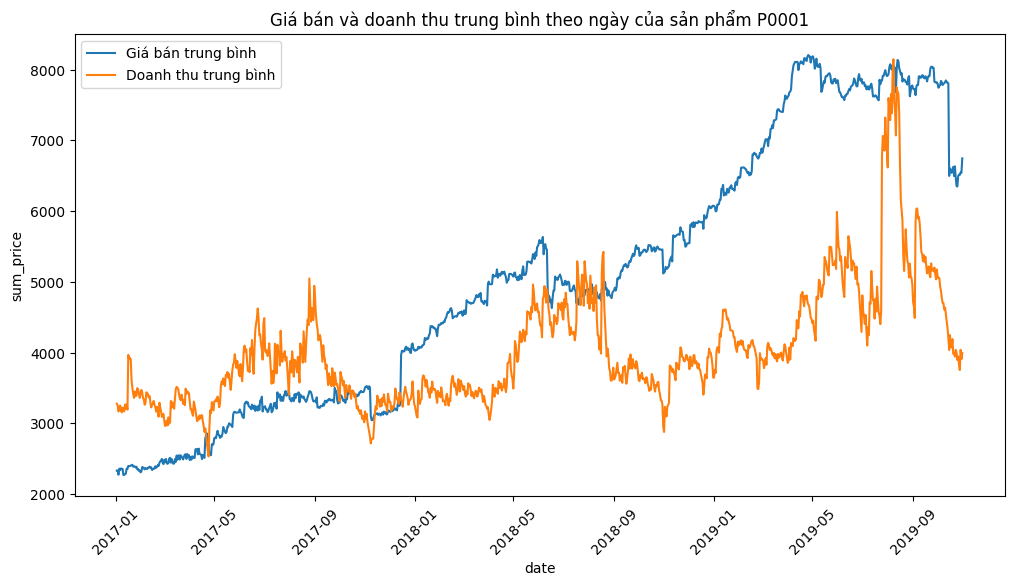

In [ ]:
# Biểu đồ xu hướng tổng doanh thu và số lượng bán theo ngày (sum_by_date_product)
# Lọc dữ liệu theo product_id
filtered_df = sum_by_date_store_df[sum_by_date_store_df['store_id'] == "S0001"]
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='date', y='sum_price', label='Giá bán trung bình')
sns.lineplot(data=filtered_df, x='date', y='sum_stock', label='Doanh thu trung bình')
plt.title("Giá bán và doanh thu trung bình theo ngày của sản phẩm P0001")
plt.xticks(rotation=45)
plt.legend()
plt.show()



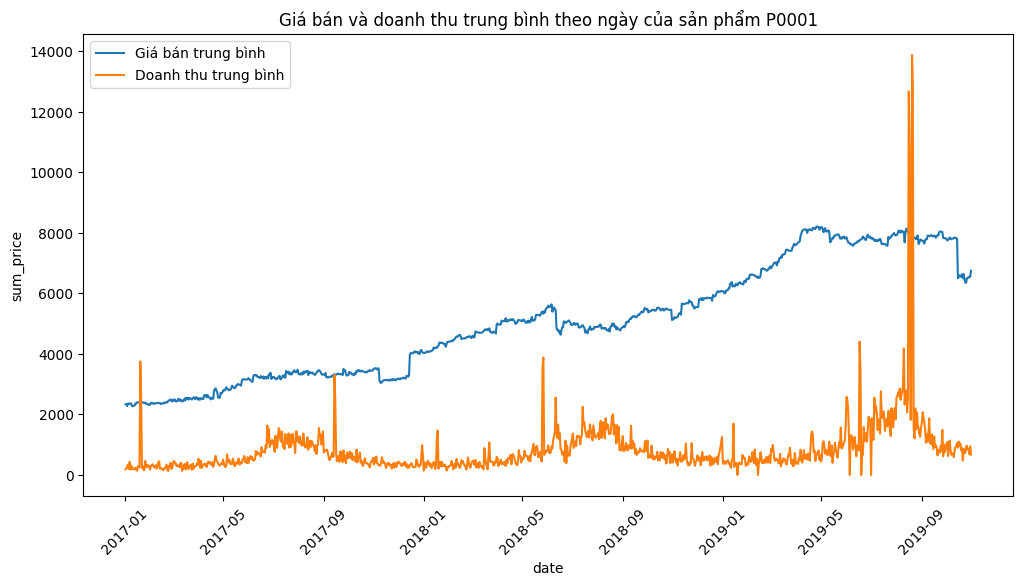

In [ ]:
# Biểu đồ xu hướng tổng doanh thu và số lượng bán theo ngày (sum_by_date_product)
# Lọc dữ liệu theo product_id
filtered_df = sum_by_date_store_df[sum_by_date_store_df['store_id'] == "S0001"]
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='date', y='sum_price', label='Giá bán trung bình')
sns.lineplot(data=filtered_df, x='date', y='sum_revenue', label='Doanh thu trung bình')
plt.title("Giá bán và doanh thu trung bình theo ngày của sản phẩm P0001")
plt.xticks(rotation=45)
plt.legend()
plt.show()



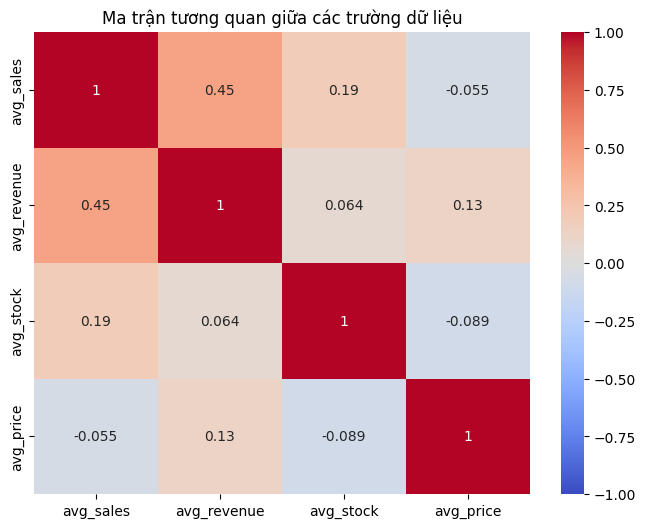

In [ ]:
# Tính toán mối tương quan giữa các trường
correlation_matrix = avg_by_date_product_df[['avg_sales', 'avg_revenue', 'avg_stock', 'avg_price']].corr()

# Vẽ heatmap biểu diễn ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các trường dữ liệu")
plt.show()


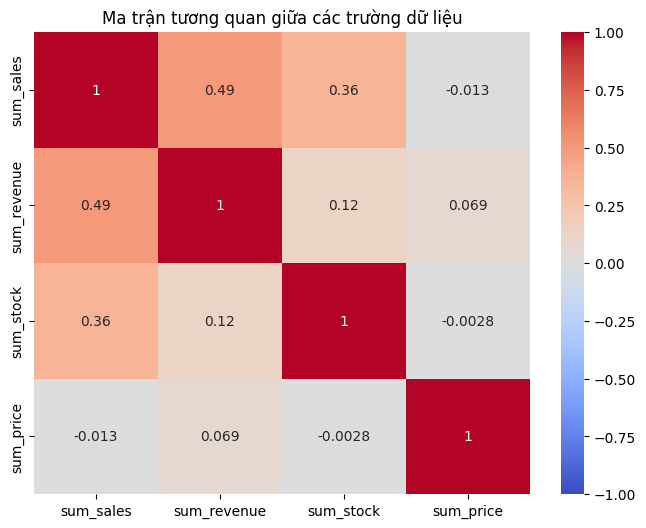

In [ ]:
# Tính toán mối tương quan giữa các trường
correlation_matrix = sum_by_date_product_df[['sum_sales', 'sum_revenue', 'sum_stock', 'sum_price']].corr()

# Vẽ heatmap biểu diễn ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các trường dữ liệu")
plt.show()


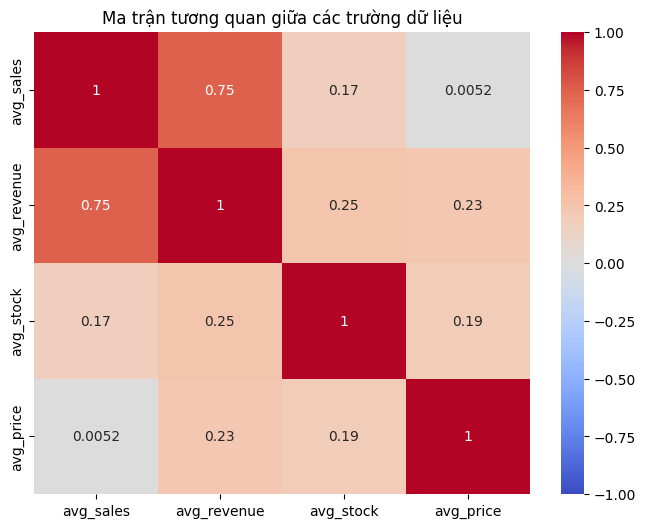

In [ ]:
# Tính toán mối tương quan giữa các trường
correlation_matrix = avg_by_date_store_df[['avg_sales', 'avg_revenue', 'avg_stock', 'avg_price']].corr()

# Vẽ heatmap biểu diễn ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các trường dữ liệu")
plt.show()


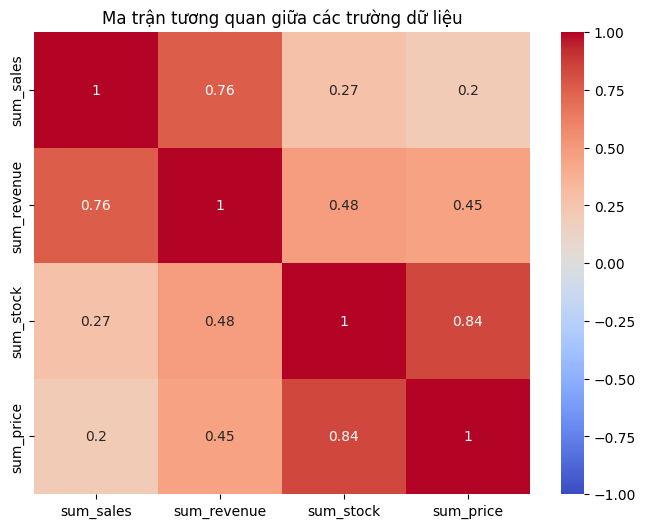

In [ ]:
# Tính toán mối tương quan giữa các trường
correlation_matrix = sum_by_date_store_df[['sum_sales', 'sum_revenue', 'sum_stock', 'sum_price']].corr()

# Vẽ heatmap biểu diễn ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các trường dữ liệu")
plt.show()


# **Biểu đồ cho truy vấn phụ**

In [ ]:
# Chuyển đổi sang Pandas DataFrame
top_products_sales_df = top_products_sales.toPandas()
top_stores_sales_df = top_stores_sales.toPandas()
avg_price_by_date_df = avg_price_by_date.toPandas()
correlation_price_sales_store_df = correlation_price_sales_store.toPandas()

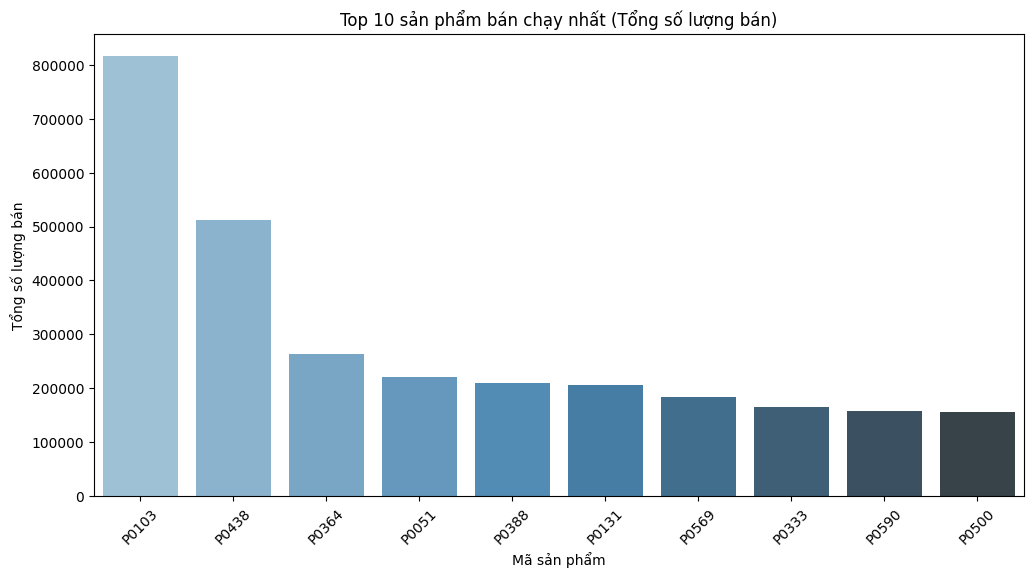

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products_sales_df, x='product_id', y='total_sales', palette='Blues_d')
plt.title('Top 10 sản phẩm bán chạy nhất (Tổng số lượng bán)')
plt.xlabel('Mã sản phẩm')
plt.ylabel('Tổng số lượng bán')
plt.xticks(rotation=45)
plt.show()


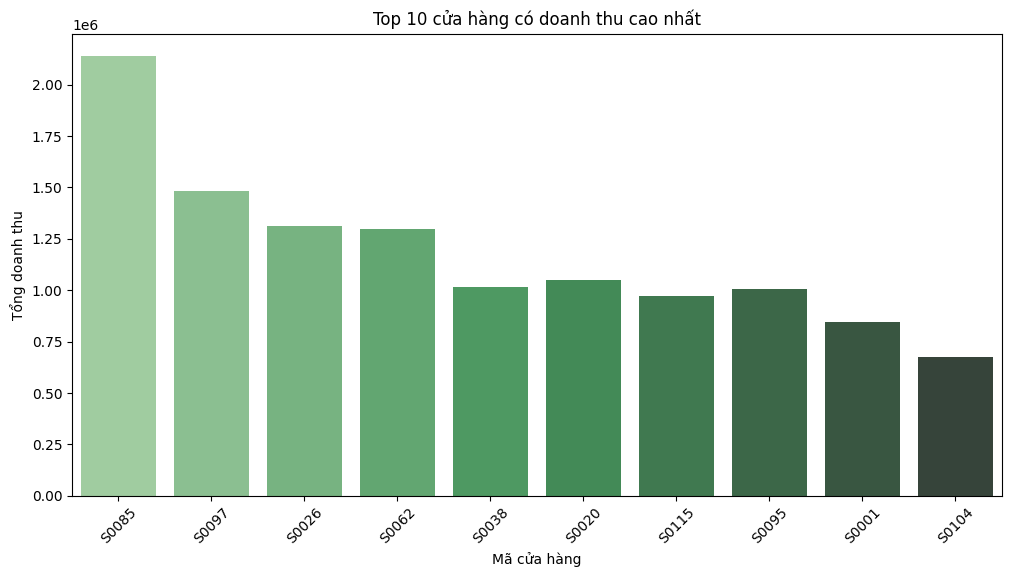

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_stores_sales_df, x='store_id', y='total_revenue', palette='Greens_d')
plt.title('Top 10 cửa hàng có doanh thu cao nhất')
plt.xlabel('Mã cửa hàng')
plt.ylabel('Tổng doanh thu')
plt.xticks(rotation=45)
plt.show()


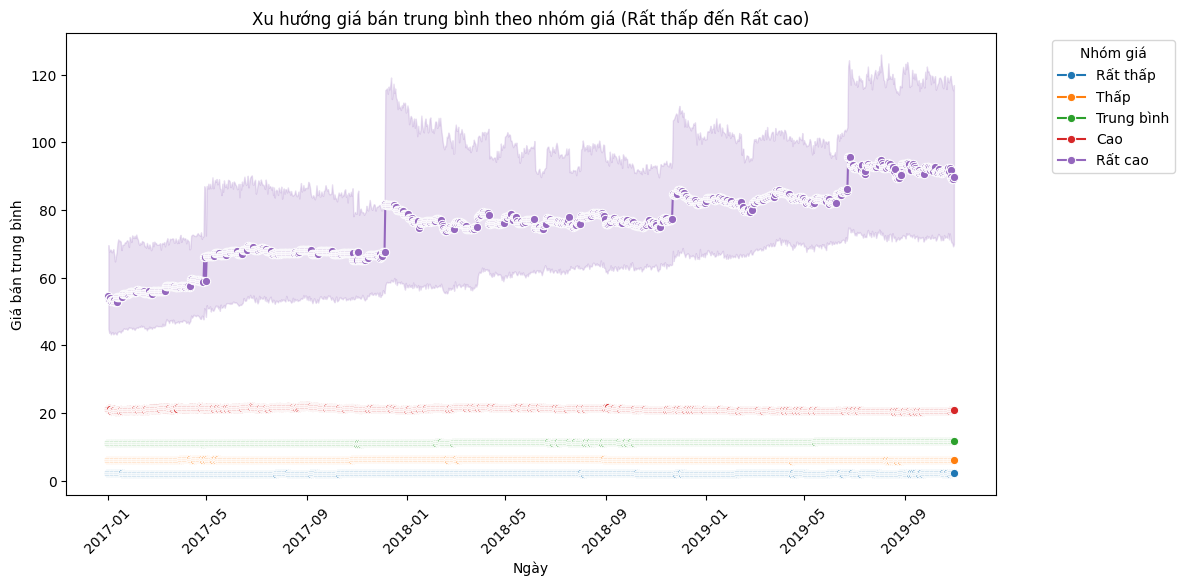

In [ ]:

avg_price_by_date_df['price_group'] = pd.qcut(avg_price_by_date_df['avg_price'], 5, labels=['Rất thấp', 'Thấp', 'Trung bình', 'Cao', 'Rất cao'])

# Vẽ biểu đồ xu hướng giá trung bình theo nhóm giá
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_by_date_df, x='date', y='avg_price', hue='price_group', marker='o')
plt.title('Xu hướng giá bán trung bình theo nhóm giá (Rất thấp đến Rất cao)')
plt.xlabel('Ngày')
plt.ylabel('Giá bán trung bình')
plt.xticks(rotation=45)
plt.legend(title='Nhóm giá', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


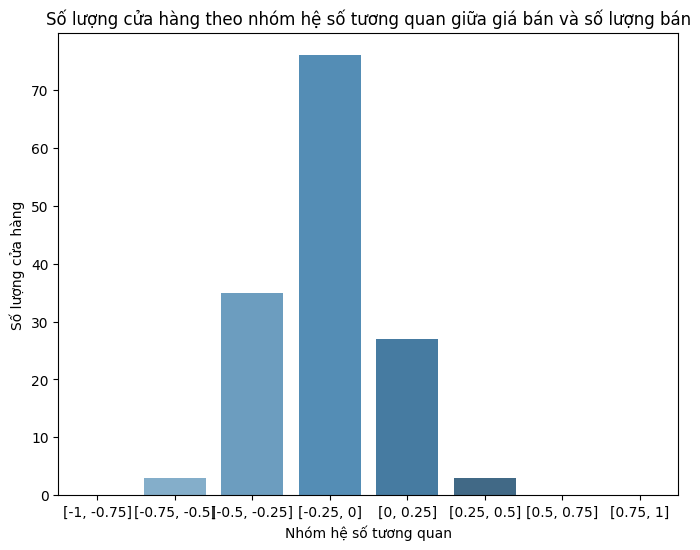

In [ ]:
# Nhóm cửa hàng theo các khoảng tương quan
correlation_price_sales_store_df['corr_group'] = pd.cut(correlation_price_sales_store_df['corr_sales_price'],
                                                        bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75,  1],
                                                        labels=['[-1, -0.75]', '[-0.75, -0.5]', '[-0.5, -0.25]', '[-0.25, 0]', '[0, 0.25]','[0.25, 0.5]', '[0.5, 0.75]', '[0.75, 1]'])

# Đếm số lượng cửa hàng trong mỗi nhóm tương quan
corr_group_counts = correlation_price_sales_store_df['corr_group'].value_counts().sort_index()

# Vẽ biểu đồ số lượng cửa hàng trong mỗi nhóm tương quan
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_group_counts.index, y=corr_group_counts.values, palette='Blues_d')
plt.title('Số lượng cửa hàng theo nhóm hệ số tương quan giữa giá bán và số lượng bán')
plt.xlabel('Nhóm hệ số tương quan')
plt.ylabel('Số lượng cửa hàng')
plt.show()
